In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics #accuracy calculation
import seaborn as sns

In [2]:
df = pd.read_excel('musicas_features.xlsx', usecols = "B:T")
df = df[(df['id'].notnull()) & (df['Ano'] != 2020)]
df = df.drop_duplicates(subset=['id'], keep='last')
df['Ano'] = df['Ano'].astype(int)
df.head()

,Posicao,Musica,Artista,Ano,id,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1.0,Balancê,Gal Costa,1980,2m1G38M0gJuE4aVPh0tmIP,1979-01-08,0.638,0.736,9.0,-10.536,1.0,0.0811,0.0849,0.000000,0.333,0.881,144.823,188667.0,4.0
1,4.0,Momentos,Joanna,1980,5ncQCIFnjpHWRXbuKFG8RP,2002-11-08,0.501,0.296,7.0,-12.018,0.0,0.0292,0.8020,0.006370,0.117,0.305,132.462,235147.0,4.0
2,5.0,Menino do Rio,Baby Consuelo,1980,6tisytwaOaBA4CAZPPdlFP,1978-09-14,0.380,0.548,0.0,-9.260,1.0,0.0333,0.7300,0.000142,0.310,0.395,152.498,263733.0,4.0
3,6.0,Toada (Na Direção do Dia),Boca Livre,1980,2LO6c0rfmBm49Qs9KtQR1W,2007-01-01,0.402,0.506,6.0,-13.094,0.0,0.0409,0.9280,0.000946,0.728,0.446,97.082,233707.0,4.0
4,9.0,Meu Bem Querer,Djavan,1980,5ogHB4oYt1C7kaWJYm5MDG,1999-03-25,0.519,0.457,9.0,-8.450,1.0,0.0326,0.7630,0.000666,0.796,0.264,81.561,254800.0,4.0


## Determinando a década de cada música

In [3]:
def obter_decada(linha):
    ano = str(linha['Ano'])
    if "198" in ano:
        return "1980"
    if "199" in ano:
        return "1999"
    if "200" in ano:
        return "2000"
    if "201" in ano:
        return "2010"
    return "-"

df['Decada'] = df.apply (lambda x: obter_decada(x), axis=1)

In [4]:
df.isnull().sum()

Posicao             0
Musica              0
Artista             0
Ano                 0
id                  0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
Decada              0
dtype: int64

##  Dividindo o dataset em base de teste e treino

In [5]:
atributos = ['danceability', 'energy', 'key', 'loudness', 'mode', 
        'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
        'valence', 'tempo', 'duration_ms', 'time_signature']

X = df[atributos]
y = pd.factorize(df['Decada'])[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [6]:
# for n_estimators in [100, 500, 1000, 10000]:
rfc = RandomForestClassifier(n_estimators=1000)

rfc.fit(X_train, y_train)

#     print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

RandomForestClassifier(n_estimators=1000)

In [11]:
rfc.predict_proba(X_test)[0:10]

array([[0.039, 0.114, 0.263, 0.584],
       [0.583, 0.193, 0.21 , 0.014],
       [0.259, 0.261, 0.283, 0.197],
       [0.189, 0.199, 0.12 , 0.492],
       [0.046, 0.146, 0.623, 0.185],
       [0.258, 0.468, 0.16 , 0.114],
       [0.203, 0.27 , 0.449, 0.078],
       [0.485, 0.239, 0.122, 0.154],
       [0.008, 0.055, 0.071, 0.866],
       [0.36 , 0.371, 0.172, 0.097]])

In [7]:
y_pred = rfc.predict(X_test)

print("accuracy_score:",metrics.accuracy_score(y_test, y_pred))
print("f1_score:",metrics.f1_score(y_test, y_pred, average='weighted'))

accuracy_score: 0.5640599001663894
f1_score: 0.5624097109662229


In [12]:
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             display_labels=[1980, 1990, 2000, 2010],
                             cmap=plt.cm.Greens,
                             normalize='true')

plt.show()

NameError: name 'plot_confusion_matrix' is not defined

## Descobrindo atributos mais importantes 

In [8]:
atributos_importancia = pd.Series(rfc.feature_importances_,index=atributos).sort_values(ascending=False)
atributos_importancia

loudness            0.176091
duration_ms         0.128512
acousticness        0.090320
energy              0.086691
speechiness         0.083961
danceability        0.083875
liveness            0.079208
tempo               0.078129
valence             0.077715
instrumentalness    0.053483
key                 0.045867
mode                0.011309
time_signature      0.004839
dtype: float64

<AxesSubplot:>

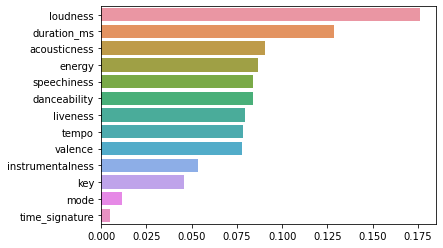

In [9]:
sns.barplot(x=atributos_importancia, y=atributos_importancia.index)

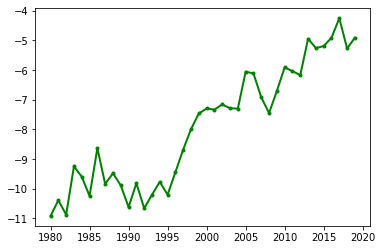

In [10]:
loudness = df.groupby(by='Ano').mean()['loudness'].reset_index()

plt.plot('Ano', 'loudness', data=loudness, marker='.', color='green', linewidth=2)